In [203]:
%load_ext autoreload

%autoreload 2
import scipy
import GCRCatalogs
import matplotlib.pyplot as plt
import pickle
from astropy.coordinates import SkyCoord, match_coordinates_3d, match_coordinates_sky
import sys
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack, join
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis')
import corner
import make_profile as prf

sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/')
import miscentering as mis
import two_halo_term as twoh
import mass_conversion as utils
import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
import astropy.units as un
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [204]:
def load(filename, **kwargs):

    with open(filename, 'rb') as fin:
        
        return pickle.load(fin, **kwargs)

In [403]:
#profile_SkySim = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/p_DC2_validation/cosmoDC2/cosmodc2_epsilon_shape_all_bins_ns.pkl')
#profile_SkySim = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/p_RedMapper_clusters/paper_dc2_galaxy_cluster_mass/data_DS/Richness_cosmodc2_flex_BPZ/individual_epsilon_shape_true_z_SkySim_all_bins.pkl')
profile_SkySim = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/p_DC2_validation/SkySim5000/SkySim5000_true_shape_all_bins_ns.pkl')
#dat_SkySim = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Galaxy_Cluster_Catalogs_details/cosmoDC2/RedMapper_galaxy_clusters.pkl')
dat_SkySim = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Galaxy_Cluster_Catalogs_details/cosmoDC2/SkySim5000_DM_halos.pkl')

In [404]:
profile_SkySim.colnames

['cluster_id',
 'M200c',
 'cluster_z',
 'radial_bin',
 'gt_av',
 'gx_av',
 'radius_av',
 'norm_sum']

In [405]:
dat_SkySim.colnames

['dec',
 'ra',
 'baseDC2/sod_halo_radius',
 'halo_id',
 'halo_mass',
 'baseDC2/sod_halo_mass',
 'redshift']

In [406]:
profile_SkySim['radial_bin'][0]

array([ 0.1       ,  0.11334498,  0.12847084,  0.14561524,  0.16504757,
        0.18707313,  0.21203799,  0.24033442,  0.27240699,  0.30875965,
        0.34996355,  0.39666611,  0.44960111,  0.50960028,  0.57760633,
        0.65468776,  0.7420557 ,  0.84108286,  0.95332519,  1.08054622,
        1.22474487,  1.3881868 ,  1.57344002,  1.78341524,  2.02141161,
        2.29116854,  2.59692447,  2.94348346,  3.33629067,  3.78151792,
        4.28616064,  4.85814783,  5.50646657,  6.24130331,  7.07420385,
        8.01825478,  9.08828909, 10.30111925, 11.67580132, 13.2339344 ,
       15.        ])

In [427]:
#profile_SkySim = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/p_DC2_validation/SkySim5000/SkySim5000_true_shape_all_bins_ns.pkl')
gt_cut = []
gx_cut = []
norm_sum_cut = []
radius_cut = []
for p in profile_SkySim:
    
    mask = (p['radial_bin'][:-1] > 1)*(p['radial_bin'][:-1] < 10)
    radius_cut.append(p['radius_av'][mask])
    gt_cut.append(p['gt_av'][mask])
    gx_cut.append(p['gx_av'][mask])
    norm_sum_cut.append(p['norm_sum'][mask])
    
profile_SkySim['radius_av'] = np.array(radius_cut)    
profile_SkySim['gt_av'] = np.array(gt_cut)
profile_SkySim['gx_av'] = np.array(gx_cut)
profile_SkySim['norm_sum'] = np.array(norm_sum_cut)

In [428]:
(profile_SkySim.colnames)

['cluster_id',
 'M200c',
 'cluster_z',
 'radial_bin',
 'gt_av',
 'gx_av',
 'radius_av',
 'norm_sum',
 'halo_id',
 'dec',
 'ra',
 'baseDC2/sod_halo_radius',
 'halo_mass',
 'baseDC2/sod_halo_mass',
 'redshift']

In [430]:
profile_SkySim['radius_av'][0]

array([1.1582320307902023, 1.3081198689865772, 1.4856786612622357,
       1.6846238001123441, 1.9040204723464984, 2.1607579523478955,
       2.4488874355978565, 2.77275200128721, 3.1498624839640845,
       3.561528433202281, 4.040639949084731, 4.575936113479575,
       5.185413486421381, 5.889779975309289, 6.673281768575222,
       7.551924091772933, 8.561885717215464, 9.709389297221213],
      dtype=object)

In [447]:
profile_SkySim['halo_id'] = profile_SkySim['cluster_id'] 
profile_SkySim = join(profile_SkySim,dat_SkySim,keys='halo_id')

In [432]:
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
z_corner = np.linspace(0.2, 1, 6)
print(z_corner)
#z_corner = [0.2, 0.35, 0.5, 0.65]
Z_bin = binning(z_corner)
rich_corner = [20,30,45, np.inf]
rich = dat_SkySim['baseDC2/sod_halo_mass']/0.71
rich = rich[rich > 1e12]
m200_sort =np.sort(rich)
m_pack = np.array_split(m200_sort, 5)
m_corner = [[m[0], m[-1]] for m in m_pack]
print(m_corner)
m_corner = np.logspace(14,15,4)
#Mass_bin = m_corner
Obs_bin = binning(m_corner)

[0.2  0.36 0.52 0.68 0.84 1.  ]
[[2623568535436.6196, 11264687297261.973], [11264687297261.973, 13573323046219.719], [13573323046219.719, 17477443237859.156], [17477443237859.156, 26334590439481.69], [26334590439481.69, 1883657153163898.8]]


In [433]:
Obs_bin

[[100000000000000.0, 215443469003188.66],
 [215443469003188.66, 464158883361277.25],
 [464158883361277.25, 1000000000000000.0]]

In [434]:
moo = clmm.Modeling(massdef = 'critical', delta_mdef = 200, halo_profile_model = 'nfw')
moo.set_cosmo(cosmo_clmm)
deff = ccl.halos.massdef.MassDef(200, 'critical', c_m_relation=None)
conc = ccl.halos.concentration.ConcentrationDiemer15(mdef=deff)

In [435]:
#profile_sky_stack = prf.stacked_profile(profile = profile_SkySim,
#                    r_in = 'radius_av',
#                    gt_in = 'gt_av', gx_in = 'gx_av',
#                    r_out = 'radius',
#                    gt_out = 'gt', gx_out = 'gx',
#                    weight = 'norm_sum',
#                    z_name = 'cluster_z', obs_name = 'M200c',
#                    Z_bin = Z_bin, Obs_bin = Obs_bin)

In [436]:
covariance_sky_stack_unique = prf.bootstrap_covariance(profile = profile_SkySim,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                   n_boot = 400,
                    z_name = 'cluster_z', obs_name = 'M200c',
                   Z_bin = Z_bin, Obs_bin = Obs_bin)

In [437]:
def corr(cov, mask):
    index = np.arange(len(cov[0]))[mask]
    size = len(index)
    a = np.zeros([size, size])
    cov_resized = np.zeros([size, size])
    for i, index_i in enumerate(index):
        for j, index_j in enumerate(index):
            a[i,j] = cov[index_i,index_j]/np.sqrt(cov[index_i,index_i]*cov[index_j,index_j])
            cov_resized[i,j] = cov[index_i,index_j]
    return a, cov_resized

In [438]:
n = len(Z_bin)*len(Obs_bin) 

In [439]:
covariance_sky_stack_unique['cov_t']

7.119244927578236e+23 .. 1.272314714839633e+23
4.2849380059801076e+24 .. 3.434700505794136e+23
1.7428243838564803e+25 .. 9.545136008940962e+23
4.62616321336372e+23 .. 9.751423650368983e+22
4.0808078731754294e+24 .. 4.0211948286419875e+23
2.8619958658814395e+25 .. 3.9568917708161744e+24
5.05936256100537e+23 .. 1.1491824628074772e+23
3.467779550141085e+24 .. 6.665903292046669e+23
1.7057932933671328e+25 .. 5.152313329300513e+24
6.457637075487739e+23 .. 1.395029505839736e+23
5.752883983367196e+24 .. 8.195229716978024e+23


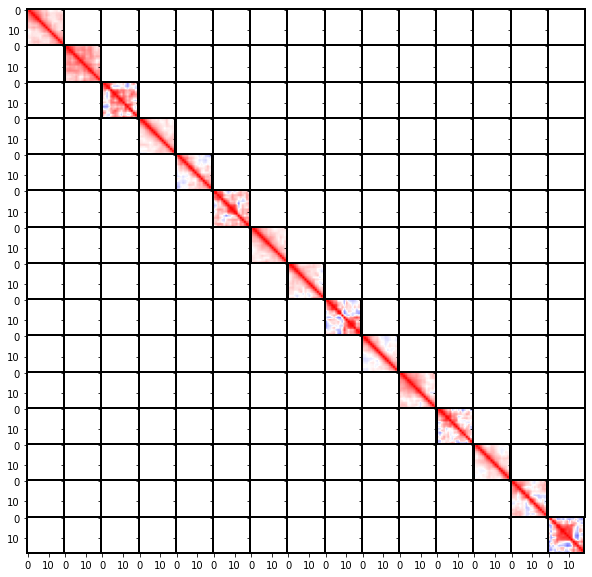

In [440]:
fig, ax = plt.subplots(n,n, figsize = (10,10), sharex = True, sharey = True)
plt.rcParams['axes.linewidth'] = 1
fig.subplots_adjust(wspace=0, hspace=0)
for i in range(n):
    cov = covariance_sky_stack_unique['cov_t'][i]
    mask = cov.diagonal() > 0
    ax[i,i].imshow(corr(cov, mask)[0], vmin = -1, vmax = 1, cmap = 'bwr')

In [441]:
%load_ext autoreload

%autoreload 2

import make_profile as prf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [448]:
s, covariance_sky_stack = prf.jackknife_maxi_covariance(profile = profile_SkySim,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    ra = 'ra', dec = 'dec',           
                    n_jack= 300,
                    z_name = 'cluster_z', obs_name = 'M200c',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

In [449]:
covariance_sky_stack.shape

(270, 270)

270


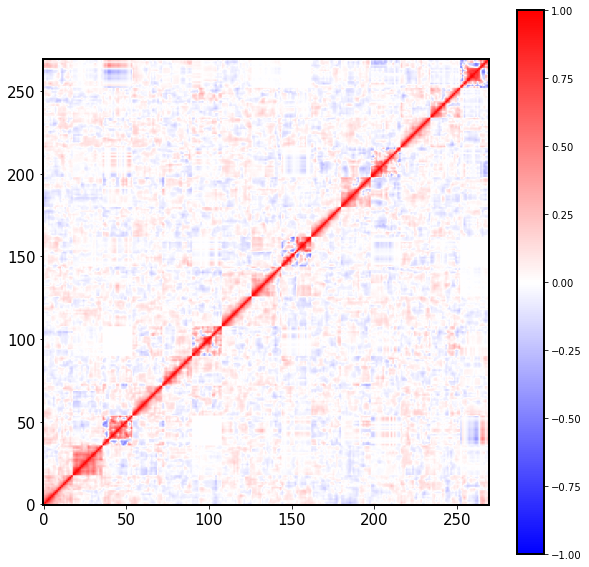

In [450]:
plt.figure(figsize = (10,10))
plt.rcParams['axes.linewidth']= 2
plt.tick_params(axis='both', which = 'major', labelsize= 15)
mask = covariance_sky_stack.diagonal() > 0
print(len(mask))
corre = corr(covariance_sky_stack, mask)[0]
plt.imshow(corre,  cmap = 'bwr', origin = 'lower', vmin = -1)
plt.colorbar()

In [ ]:
len(corre.flatten()[corre.flatten() == 0])

In [ ]:
plt.plot(covariance_sky_stack.diagonal())
plt.yscale('log')

In [ ]:
moo = clmm.Modeling(massdef = 'critical', delta_mdef = 200, halo_profile_model = 'nfw')
moo.set_cosmo(cosmo_clmm)
deff = ccl.halos.massdef.MassDef(200, 'critical', c_m_relation=None)
conc = ccl.halos.concentration.ConcentrationDiemer15(mdef=deff)
def modele_ds(r, logm, c, cluster_z):

    m = 10.**logm 
    
    moo.set_mass(m), moo.set_concentration(c)
    
    deltasigma = []
        
    for i, xr in enumerate(r):
    
        deltasigma.append(moo.eval_excess_surface_density(xr, cluster_z))
    
    return np.array(deltasigma)

In [ ]:
def chi2(par):
    
    data_vector = []
    model_vector = []
    

    for i,p in enumerate(profile_sky_stack):
        
        mask = (p['radius'] > 0)
        
        data_vector.extend(p['gt'][mask])
        

        
        model_vector.extend(modele_ds(p['radius'], par[i], 1, p['z_mean'])[mask])
        
        if par[i] < 13: return np.inf
        if par[i] > 16: return np.inf
        
    inv_cov = np.linalg.inv(np.diag(covariance_sky_stack.diagonal()))
    inv_cov = np.linalg.inv(np.diag(covariance_sky_stack.diagonal()))
    
    delta = np.array(data_vector) - np.array(model_vector)
    
    return np.sum(delta*inv_cov.dot(delta))

init = tuple([14 for i in profile_sky_stack])
error = tuple([0.001 for i in profile_sky_stack])
m = Minuit.from_array_func(chi2, init,error, errordef=1)
m.get_param_states()
m.migrad()
m.hesse()

In [ ]:
p = [m.values[i] for i,p in enumerate(profile_sky_stack)]
err = [m.errors[i] for i,p in enumerate(profile_sky_stack)]

In [ ]:
plt.errorbar( np.log10(profile_sky_stack['obs_mean']), p, err)
plt.plot(p, p)

In [ ]:
m.values[0]

In [ ]:
m.matrix()